<a href="https://colab.research.google.com/github/mgiorgi13/brain_tumor_classifier/blob/mattia/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In this Jupiter notebook, you are creating a Convolutional Neural Network (CNN) using TensorFlow and Keras to classify brain MRI images. The goal is to detect potential brain tumors through the analysis of MRI images. In this section, we import the necessary libraries to create the CNN and load the images.

# **Importing Libraries**

In this paragraph, we have imported the necessary libraries to create the CNN. TensorFlow and Keras are the main frameworks that we will use to create the convolutional neural network. Additionally, we have imported other useful libraries such as OpenCV (cv2) for image preprocessing, PIL for image manipulation, and Matplotlib for image visualization.

In [ ]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
import os
import glob
import shutil
from sklearn.utils import shuffle
import zipfile
import cv2
import imutils
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:
dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# **Folder reorganization**

The next code snippet renames the image files in the training and testing folders by adding the subfolder name and an incrementing number to the filename. 

In [ ]:
# class list
classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
class_dimensions = {} # list of counters, one for each class
for cls in classes:
  class_dimensions[cls] = 0
  
# go into training folder and then into each subfolder and rename files with folder name plus incrementing number
os.chdir('/content/drive/MyDrive/BrainTumorDataset/Training')
for folder in glob.glob('*'):
    os.chdir(folder)
    i = 1
    for file in glob.glob('*'):
        # get file extension
        ext = file.split('.')[1]
        os.rename(file, folder + '_' + str(i) + '.' + ext)
        i += 1
    class_dimensions[folder] = i-1
    os.chdir('..')

# go into testing folder and then into each subfolder and rename files with folder name plus incrementing number
os.chdir('/content/drive/MyDrive/BrainTumorDataset/Testing')
for folder in glob.glob('*'):
    os.chdir(folder)
    i = class_dimensions[folder] + 1 # start from previous counter to have incremental ID for each image
    for file in glob.glob('*'):
        # get file extension
        ext = file.split('.')[1]
        os.rename(file, folder + '_' + str(i) + '.' + ext)
        i += 1
    class_dimensions[folder] = i-1
    os.chdir('..')

print(class_dimensions)

{'glioma_tumor': 926, 'meningioma_tumor': 937, 'no_tumor': 500, 'pituitary_tumor': 901}


This following code snippet creates a unified dataset directory with subfolders for each class required for training the CNN.

In [ ]:
training_path = dataset_path + '/Training'
testing_path = dataset_path + '/Testing'

if os.path.exists(dataset_path + '/Preprocessed/Unified'):
  shutil.rmtree(dataset_path + '/Preprocessed')

os.makedirs(dataset_path + '/Preprocessed/Unified')

# Copia le sottocartelle delle classi da train a dataset con sovrascrittura
for cls in classes:
  src_path = os.path.join(training_path, cls)
  dst_path = os.path.join(dataset_path + '/Preprocessed/Unified', cls)
  shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

# Copia le sottocartelle delle classi da test a dataset con sovrascrittura
for cls in classes:
  src_path = os.path.join(testing_path, cls)
  dst_path = os.path.join(dataset_path + '/Preprocessed/Unified', cls)
  shutil.copytree(src_path, dst_path, dirs_exist_ok=True)


# **Split the dataset**

The following function split the dataset into training, validation and test sets, using the corresponding splitting percentage value 60%, 20% and 20%.

In [ ]:
import os
import random
import shutil

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

# Crea le cartelle per il set di test, di validazione e di addestramento
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(train_path, exist_ok=True)

# Percorso completo delle classi
class_paths = [os.path.join(base_path, c) for c in os.listdir(base_path)]

# Itera attraverso le classi
for class_path in class_paths:
    class_name = os.path.basename(class_path)

    # Creazione delle cartelle per il set di test, di validazione e di addestramento per ogni classe
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)

    # Ottieni la lista di file per la classe corrente
    files = os.listdir(class_path)

    # Shuffle dei file
    random.shuffle(files)

    # Calcola il numero di file per il set di test e di validazione (20% per il set di test e 20% per il set di validazione)
    num_files = len(files)
    num_test = int(0.2 * num_files)
    num_val = int(0.2 * num_files)

    # Copia i file nel set di test
    test_files = files[:num_test]
    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_path, class_name, file)
        shutil.copyfile(src, dst)

    # Copia i file nel set di validazione
    val_files = files[num_test:num_test+num_val]
    for file in val_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(val_path, class_name, file)
        shutil.copyfile(src, dst)

    # Copia i file nel set di addestramento
    train_files = files[num_test+num_val:]
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_path, class_name, file)
        shutil.copyfile(src, dst)


In [ ]:
# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

for subfolder in os.listdir(test_path):
    subfolder_path = os.path.join(test_path, subfolder)
    
    # Verifica se è una cartella
    if os.path.isdir(subfolder_path):
        # Ottieni la lista dei file
        file_list = os.listdir(subfolder_path)
        
        # Stampa il numero di file
        print(f"La sottocartella {subfolder} contiene {len(file_list)} file.")

# **Class balance analysis**

We created a histogram to analyze the balance of the classes

In [ ]:
glioma_tumor_path = dataset_path + '/Preprocessed/Unified/glioma_tumor'
meningioma_tumor_path = dataset_path + '/Preprocessed/Unified/meningioma_tumor'
no_tumor_path = dataset_path + '/Preprocessed/Unified/no_tumor'
pituitary_tumor_path = dataset_path + '/Preprocessed/Unified/pituitary_tumor'

glioma_tumor_entries = os.listdir(glioma_tumor_path)
meningioma_entries = os.listdir(meningioma_tumor_path)
no_tumor_entries = os.listdir(no_tumor_path)
pituitary_tumor_entries = os.listdir(pituitary_tumor_path)

train_entries = glioma_tumor_entries + meningioma_entries + no_tumor_entries + pituitary_tumor_entries

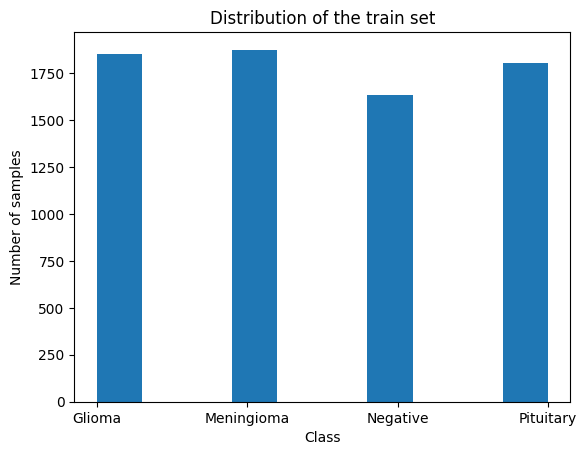

In [ ]:
glioma_samples = [entry for entry in train_entries if 'glioma' in entry]
meningioma_samples = [entry for entry in train_entries if 'meningioma' in entry]
negative_samples = [entry for entry in train_entries if 'no' in entry]
pituitary_samples = [entry for entry in train_entries if 'pituitary' in entry]

# Creo la lista dei label per la classe positiva
glioma_labels = ['Glioma'] * len(glioma_samples)

# Creo la lista dei label per la classe negativa
meningioma_labels = ['Meningioma'] * len(meningioma_samples)

# Creo la lista dei label per la classe positiva
negative_labels = ['Negative'] * len(negative_samples)

# Creo la lista dei label per la classe negativa
pituitary_labels = ['Pituitary'] * len(pituitary_samples)

# Unisco le due liste
labels = glioma_labels + meningioma_labels + negative_labels + pituitary_labels

# Creo l'istogramma
fig, ax = plt.subplots()
ax.hist(labels)

# Aggiungo le etichette
ax.set_xticks(['Glioma', 'Meningioma', 'Negative', 'Pituitary'])
ax.set_xlabel('Class')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of the train set')

plt.show()

At this point we calculate how many entries we have to consdier for each class and then we calculate, if needed, how many images we have to generate with data augmentation for the minority class.

In [ ]:
expected_samples_per_class = len(train_entries)//4
print("Number of expected images per class: " + str(expected_samples_per_class) + '\n')

glioma_tumor = random.sample(glioma_samples, expected_samples_per_class)
print("Number of sampled GLIOMA tumor images: " + str(len(glioma_tumor)))

meningioma_tumor = random.sample(meningioma_samples, expected_samples_per_class)
print("Number of sampled MENINGIOMA tumor images: " + str(len(meningioma_tumor)))

pituitary_tumor = random.sample(meningioma_samples, expected_samples_per_class)
print("Number of sampled PITUITARY tumor images: " + str(len(pituitary_tumor)))

negative_samples_needed = expected_samples_per_class - len(negative_samples)
sampled_negative = random.sample(negative_samples, negative_samples_needed)
print("\nNumber of sampled NEGATIVE tumor images: " + str(len(negative_samples)))
print("Number of sampled NEGATIVE tumor images to perform augmentation: " + str(len(sampled_negative)))


Number of expected images per class: 1790

Number of sampled GLIOMA tumor images: 1790
Number of sampled MENINGIOMA tumor images: 1790
Number of sampled PITUITARY tumor images: 1790

Number of sampled NEGATIVE tumor images: 1632
Number of sampled NEGATIVE tumor images to perform augmentation: 158


# **Data Augmentation**

In [ ]:
def random_flip_or_rotation(original_image):
  '''
  random_flip_or_rotation randomly rotates or flips the image
  :param original_image: the image on which to perform the transformation
  :return: the transformed image
  '''
  if random.randint(0,1): # decide whether to flip the image or not
    horizontal = random.randint(0,1)
    if horizontal:
      new_image = tf.image.flip_left_right(original_image)
    else:
      new_image = tf.image.flip_up_down(original_image)
  else: # rotate the image of a random degree (between 90° and 270°)
    k = random.randint(1,3)
    new_image = tf.image.rot90(original_image, k)

  return np.asarray(new_image)

In [ ]:
glioma_tumor_path = dataset_path + '/Preprocessed/Unified/glioma_tumor/'
meningioma_tumor_path = dataset_path + '/Preprocessed/Unified/meningioma_tumor/'
no_tumor_path = dataset_path + '/Preprocessed/Unified/no_tumor/'
pituitary_tumor_path = dataset_path + '/Preprocessed/Unified/pituitary_tumor/'

glioma_tumor_entries = os.listdir(glioma_tumor_path)
meningioma_entries = os.listdir(meningioma_tumor_path)
no_tumor_entries = os.listdir(no_tumor_path)
pituitary_tumor_entries = os.listdir(pituitary_tumor_path)

In [ ]:
# balance no tumor class

no_tumor_random_entries = random.sample(no_tumor_entries, 316)

i = len(no_tumor_entries) + 1 
for entry in no_tumor_random_entries: # store cropped normal cell augmented images
  img = cv2.imread(no_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(no_tumor_path + 'A_no_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1

In [ ]:
i = len(glioma_tumor_entries) + 1 
for entry in glioma_tumor_entries: # store cropped normal cell augmented images
  img = cv2.imread(glioma_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(glioma_tumor_path + 'A_glioma_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1

i = len(meningioma_entries) + 1 
for entry in meningioma_entries: # store cropped normal cell augmented images
  img = cv2.imread(meningioma_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(meningioma_tumor_path + 'A_meningioma_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1

i = len(no_tumor_entries) + 1 
for entry in no_tumor_entries: # store cropped normal cell augmented images
  img = cv2.imread(no_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(no_tumor_path + 'A_no_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1

i = len(pituitary_tumor_entries) + 1 
for entry in pituitary_tumor_entries: # store cropped normal cell augmented images
  img = cv2.imread(pituitary_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(pituitary_tumor_path + 'A_pituitary_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1